In [2]:
# .venv\Scripts\activate.bat
import sys
!{sys.executable} -m pip install gender-guesser

In [3]:
import numpy as np
import pandas as pd

# import gender_guesser.detector as gender
import nltk
nltk.download(['punkt','stopwords','vader_lexicon'])
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
# import text2emotion as te
import matplotlib.pyplot as plt
%matplotlib inline
import re
# from wordcloud import WordCloud, ImageColorGenerator

from collections import defaultdict

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# preview data
data = pd.read_csv('static/data/reviews_50.csv')
data.head(3)

,Professor,Class Code,Class Name,Term Taken,COVID 19 Flag,Date Submitted,Grade,Review
0,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 27, 2020",A,One of the BEST profs at UCLA!! Take her if yo...
1,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 23, 2020",A,I don't say this lightly: she is an amazing pr...
2,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 17, 2020",NR,**Extenuating circumstances warning** I took t...


In [5]:
set(data['Grade'])

{' B',
 ' B+',
 ' C+',
 'A',
 'A+',
 'A-',
 'B',
 'B+',
 'B-',
 'C',
 'C+',
 'C-',
 'D',
 'D+',
 'I',
 'NR',
 'P',
 'U',
 nan}

In [6]:
# feature engineering

# name and review
data['First_Name'] = [name[0] for name in data["Professor"].str.split()]
data['Last_Name'] = [name[1] for name in data["Professor"].str.split()]
data['Review'] = [review.lower() for review in data['Review']]
# bigrams
data['Bigrams'] = [list(nltk.bigrams(review.split(' '))) for review in data['Review']]

# gender
data['All_Reviews'] = data.groupby(['Professor'])['Review'].transform(lambda x: ','.join(x)).str.lower()
# data.head(3)
data_gender =  data[['Professor', 'All_Reviews']].drop_duplicates().reset_index(drop=True)
gender_guess = {}
for idx, row in data_gender.iterrows():
    f_prns = [r'\bshe\b',r'\bher\b',r'\bhers\b']
    m_prns = [r'\bhe\b','r\bhim\b',r'\bhis\b']
    f_count = sum([len(re.findall(prn, row['All_Reviews'])) for prn in f_prns])
    m_count = sum([len(re.findall(prn, row['All_Reviews'])) for prn in m_prns])
    # print(f_count,m_count)
    if f_count > m_count:
        gender_guess[row['Professor']] = ('Female')
    elif m_count > f_count:
        gender_guess[row['Professor']] = ('Male')
    else:
        gender_guess[row['Professor']] = ('Unsure (equal or no pronouns)')
    # print(gender_guess)
print(gender_guess)
data['Gender_Pronouns'] = data['Professor'].map(gender_guess)
# # # d = gender.Detector()
# # # data['Gender'] = [d.get_gender(first_name) for first_name in data['First_Name']]

# grade
grade_dict = ['A+','A','A-','B+','B','B-','C+','C','C-','D+','D','D-','F','P','NR']
gpa_dict = [4.0, 4.0, 3.7, 3.3, 3, 2.7, 2.3, 2, 1.7, 1.3, 1, 0.7, 0, 'NA','NA']
grade_gpa_dict = dict(zip(grade_dict, gpa_dict))
grade_gpa_dict

# sentiment
sia = SentimentIntensityAnalyzer()
data['Sentiment'] = [sia.polarity_scores(review) for review in data['Review']]
data['Pos_Score'] = [sent['pos'] for sent in data['Sentiment']]
data['Neg_Score'] = [sent['neg'] for sent in data['Sentiment']]
data['PosNeg_Sentiment'] = [sent['pos'] > sent['neg'] for sent in data['Sentiment']]

# upper div
class_code2 = [code.split(' ')[-1] for code in data['Class Code']]
code_chars = [[char for char in code] for code in class_code2]
num_code = [[char for char in char_list if char.isnumeric()] for char_list in code_chars]
data['Class_Code_Num'] = [int(''.join(nums)) for nums in num_code]
data['Upper_Div'] = [code >= 100 for code in data['Class_Code_Num']]

{'Sherry Gong': 'Female', 'Jasmine Trice': 'Female', 'Peiyun Lee': 'Female', 'Adrienne Lavine': 'Female', 'Sharmila Venugopal': 'Female', 'Scott H Chandler': 'Male', 'David Gorshein': 'Male', 'Sander M Goldberg': 'Male', 'Brent Corbin': 'Male', 'Anish Nag': 'Male', 'Rana Khankan': 'Female', 'J.P. Maloy': 'Male', 'Hung Ding Pham': 'Male', 'Debra B Pires': 'Female', 'Jennifer Casey': 'Female', 'Laurence Lavelle': 'Male', 'Hung V Pham': 'Male', 'Philip Chodrow': 'Male', 'Claudia Pena': 'Female', 'Andrea Ghez': 'Female', 'Caitlin Solone': 'Female', 'Smadar Naoz': 'Female', 'Christy Hazel': 'Female', 'Rose Morris-Wright': 'Female', 'Eric Min': 'Male', 'Vinay Lal': 'Male', 'Laura Cladek': 'Female', 'Maria Cha': 'Female', 'Anthony R Friscia': 'Male', 'Nicolas Christou': 'Male', 'Juana Sanchez': 'Female', 'Kristopher F Fletcher': 'Male', 'Anastassia N Alexandrova': 'Female', 'Christian Evan Beren': 'Male', 'Emily A Carter': 'Female', 'Clover May': 'Female'}


In [7]:
data.head(3)

,Professor,Class Code,Class Name,Term Taken,COVID 19 Flag,Date Submitted,Grade,Review,First_Name,Last_Name,Bigrams,All_Reviews,Gender_Pronouns,Sentiment,Pos_Score,Neg_Score,PosNeg_Sentiment,Class_Code_Num,Upper_Div
0,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 27, 2020",A,one of the best profs at ucla!! take her if yo...,Sherry,Gong,"[(one, of), (of, the), (the, best), (best, pro...",one of the best profs at ucla!! take her if yo...,Female,"{'neg': 0.0, 'neu': 0.768, 'pos': 0.232, 'comp...",0.232,0.000,True,32,False
1,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 23, 2020",A,i don't say this lightly: she is an amazing pr...,Sherry,Gong,"[(i, don't), (don't, say), (say, this), (this,...",one of the best profs at ucla!! take her if yo...,Female,"{'neg': 0.061, 'neu': 0.772, 'pos': 0.167, 'co...",0.167,0.061,True,32,False
2,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 17, 2020",NR,**extenuating circumstances warning** i took t...,Sherry,Gong,"[(**extenuating, circumstances), (circumstance...",one of the best profs at ucla!! take her if yo...,Female,"{'neg': 0.067, 'neu': 0.716, 'pos': 0.217, 'co...",0.217,0.067,True,32,False


In [8]:
# tokenize reviews
review_tokens = [nltk.word_tokenize(review) for review in data['Review']]
# review_tokens[0][:5]
# remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['.',',','!', '&','(',')','%', '-',':',"'",';',
                   'class', 'lecture','lectures', 'students','quarter','discussion',
                   'like', 'really','pretty', 'lot', 'much', 'many','well','one','even',
                   'us','took','take','though','gives','things','however','actually',
                   'also', 'would', 'get','go','got','going',
                   'even','know','sure','makes','made',
                   "n't","'s","'ve","'re","'ll"]) # add some stopwords
filt_review_tokens = [[word for word in review if not word.lower() in stop_words] for review in review_tokens]
data['Review_Token'] = filt_review_tokens
data['Review_Filt'] = [' '.join(tokens) for tokens in filt_review_tokens] # filtered for stopwords
data.head(4)

,Professor,Class Code,Class Name,Term Taken,COVID 19 Flag,Date Submitted,Grade,Review,First_Name,Last_Name,...,All_Reviews,Gender_Pronouns,Sentiment,Pos_Score,Neg_Score,PosNeg_Sentiment,Class_Code_Num,Upper_Div,Review_Token,Review_Filt
0,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 27, 2020",A,one of the best profs at ucla!! take her if yo...,Sherry,Gong,...,one of the best profs at ucla!! take her if yo...,Female,"{'neg': 0.0, 'neu': 0.768, 'pos': 0.232, 'comp...",0.232,0.000,True,32,False,"[best, profs, ucla, chance, 100, sometimes, co...",best profs ucla chance 100 sometimes confusing...
1,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 23, 2020",A,i don't say this lightly: she is an amazing pr...,Sherry,Gong,...,one of the best profs at ucla!! take her if yo...,Female,"{'neg': 0.061, 'neu': 0.772, 'pos': 0.167, 'co...",0.167,0.061,True,32,False,"[say, lightly, amazing, professor, s-tier, obv...",say lightly amazing professor s-tier obviously...
2,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 17, 2020",NR,**extenuating circumstances warning** i took t...,Sherry,Gong,...,one of the best profs at ucla!! take her if yo...,Female,"{'neg': 0.067, 'neu': 0.716, 'pos': 0.217, 'co...",0.217,0.067,True,32,False,"[*, *, extenuating, circumstances, warning, *,...",* * extenuating circumstances warning * * fina...
3,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 30, 2020",A,sherry gong is extremely helpful and kind. as ...,Sherry,Gong,...,one of the best profs at ucla!! take her if yo...,Female,"{'neg': 0.039, 'neu': 0.825, 'pos': 0.137, 'co...",0.137,0.039,True,32,False,"[sherry, gong, extremely, helpful, kind, winte...",sherry gong extremely helpful kind winter 2020...


In [9]:
data.to_csv('reviews_new.csv',index=False)

In [10]:
# male, female data
data_m = data.loc[data['Gender_Pronouns'] == 'Male']
data_f = data.loc[data['Gender_Pronouns'] == 'Female']
print(len(data_f.index))
print(len(data_m.index))

391
446


In [11]:
data_m.head(3)

,Professor,Class Code,Class Name,Term Taken,COVID 19 Flag,Date Submitted,Grade,Review,First_Name,Last_Name,...,All_Reviews,Gender_Pronouns,Sentiment,Pos_Score,Neg_Score,PosNeg_Sentiment,Class_Code_Num,Upper_Div,Review_Token,Review_Filt
108,Scott H Chandler,Neurosc M101A,Neuroscience: From Molecules to Mind -- Cellul...,Fall 2019,Pre COVID-19,"Submitted June 30, 2020",A-,i would say chandler's module was the most dif...,Scott,H,...,i would say chandler's module was the most dif...,Male,"{'neg': 0.061, 'neu': 0.834, 'pos': 0.105, 'co...",0.105,0.061,True,101,True,"[say, chandler, module, difficult, 101a, modul...",say chandler module difficult 101a module heav...
109,Scott H Chandler,Neurosc M101A,Neuroscience: From Molecules to Mind -- Cellul...,Fall 2019,Pre COVID-19,"Submitted Dec. 18, 2019",A-,no! ns m101a is not the hardest class you will...,Scott,H,...,i would say chandler's module was the most dif...,Male,"{'neg': 0.109, 'neu': 0.722, 'pos': 0.169, 'co...",0.169,0.109,True,101,True,"[ns, m101a, hardest, ever, curve, start, b, fr...",ns m101a hardest ever curve start b freshmen t...
110,Scott H Chandler,Neurosc M101A,Neuroscience: From Molecules to Mind -- Cellul...,Fall 2020,Pre COVID-19,"Submitted May 10, 2021",P,everyone seems to love dr. chandler for some r...,Scott,H,...,i would say chandler's module was the most dif...,Male,"{'neg': 0.14, 'neu': 0.785, 'pos': 0.075, 'com...",0.075,0.140,False,101,True,"[everyone, seems, love, dr., chandler, reason,...",everyone seems love dr. chandler reason think ...


In [12]:
def get_freq_dict(word_list):
    freq_dict = defaultdict( int )
    for w in word_list:
        freq_dict[w] += 1
    return freq_dict

In [13]:
# get bag of words representation for JS word frequency plot
m_all_review_words = ' '.join(data_m['Review_Filt'].values).split(' ') # remove stopwords
f_all_review_words = ' '.join(data_f['Review_Filt'].values).split(' ') # remove stopwords
m_word_freq = get_freq_dict(m_all_review_words)
f_word_freq = get_freq_dict(f_all_review_words)
# convert to df for export
m_word_freq_df = pd.DataFrame.from_dict(m_word_freq,orient='index', columns = ['count'])
m_word_freq_df.insert(loc=0, column='word', value=m_word_freq_df.index)
m_word_freq_df.sort_values(by=['count'],inplace=True,ascending=False)
m_word_freq_df.reset_index(drop=True,inplace=True)
f_word_freq_df = pd.DataFrame.from_dict(f_word_freq,orient='index', columns = ['count'])
f_word_freq_df.insert(loc=0, column='word', value=f_word_freq_df.index)
f_word_freq_df.sort_values(by=['count'],inplace=True,ascending=False)
f_word_freq_df.reset_index(drop=True,inplace=True)

m_word_freq_df.to_csv('static/data/male_prof_word_freqs.csv',index=True)
f_word_freq_df.to_csv('static/data/female_prof_word_freqs.csv',index=True)

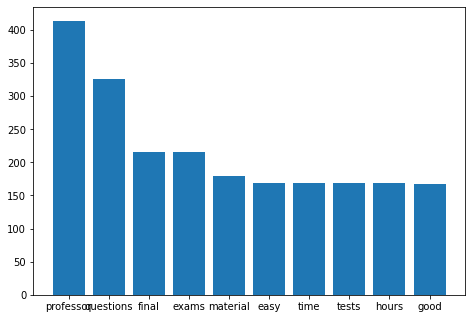

In [14]:
male_reviews = ' '.join([word for review in data_m['Review_Token'] for word in review])
male_review_list = male_reviews.split(' ')
male_freq = defaultdict( int )
for w in male_review_list:
    male_freq[w] += 1
male_freq = {key:val for key,val in male_freq.items() if val > 2}
male_freq_df = pd.DataFrame.from_dict(male_freq,orient='index')
male_freq_df = male_freq_df.reset_index().rename(columns={"index": "word", 0: "frequency"}).sort_values(by=['frequency'],ascending=False)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(male_freq_df['word'][:10],male_freq_df['frequency'][:10])
plt.show()

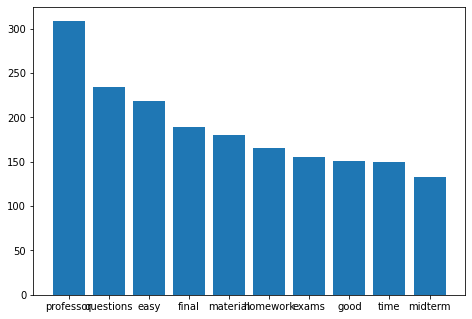

In [15]:
female_reviews = ' '.join([word for review in data_f['Review_Token'] for word in review])
female_review_list = female_reviews.split(' ')
female_review_list
female_freq = defaultdict( int )
for w in female_review_list:
    female_freq[w] += 1
female_freq = {key:val for key,val in female_freq.items() if val > 2}
female_freq_df = pd.DataFrame.from_dict(female_freq,orient='index')
female_freq_df = female_freq_df.reset_index().rename(columns={"index": "word", 0: "frequency"}).sort_values(by=['frequency'],ascending=False)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(female_freq_df['word'][:10],female_freq_df['frequency'][:10])
plt.show()

to do:
- look for ways to filter for sentiment words
- sentiment analysis
- add correlation with grade (once scraped)
- get total number of words in all reviews for F/M to calculate percentages to normalize
-remove names other proper nouns

In [16]:
# Combine female and male freqs
result = pd.merge(female_freq_df, male_freq_df, how="outer", on=["word"])
result.fillna(0, inplace=True)
result = result.rename(columns={"frequency_x": "female", "frequency_y": "male"})
result = result.astype({'female': 'int32','male':'int32'})
result.to_csv('static/data/prof_word_freqs.csv',index=False)

In [17]:
result

,word,female,male
0,professor,309,414
1,questions,234,326
2,easy,218,168
3,final,189,216
4,material,180,179
...,...,...,...
1840,known,0,3
1841,individually,0,3
1842,perfectly,0,3
1843,builds,0,3


In [22]:
result2 = pd.melt(result,id_vars=['word'],var_name='gender', value_name='count')
result2.sort_values(by=['count'],inplace=True,ascending=False)
result2.to_csv('static/data/prof_word_freqs_tidy.csv',index=False)